Подключение библиотек

In [1]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical

import re
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from os import listdir

Удаление папок если они уже есть

In [2]:
  if os.path.exists('data50to50'):
    shutil.rmtree(os.path.join(os.getcwd(), 'data50to50'))

  if os.path.exists('data80to20'):
    shutil.rmtree(os.path.join(os.getcwd(), 'data80to20'))
  
  if os.path.exists('smiles'):
    shutil.rmtree(os.path.join(os.getcwd(), 'smiles'))
  
  if os.path.exists('graphics'):
    shutil.rmtree(os.path.join(os.getcwd(), 'graphics'))
  
  if os.path.exists('smiles_img.zip'):
    !rm smiles_img.zip

In [3]:
ALL_HISTORY = pd.DataFrame(columns=['Dataset Split Variant', 'Epoches', 'Batch Size', 'Layers', 'Optimizer', 
                                    'Learning Rate', 'Loss Function', 'Final Train Accuracy',
                                    'Final Valid Accuracy', 'Final Train Loss', 'Final Valid Loss'])

Загрузка архива с изображениями

In [4]:
if os.path.exists("smiles_img.zip") is False:
  !gdown https://drive.google.com/uc?id=1IgkY4ugFLgVyzTFjwskwE6lFfBdTJD2P

Downloading...
From: https://drive.google.com/uc?id=1IgkY4ugFLgVyzTFjwskwE6lFfBdTJD2P
To: /content/smiles_img.zip
100% 186k/186k [00:00<00:00, 55.1MB/s]


Распаковка архива с изображениями

In [5]:
if os.path.exists('smiles') is False:
  !unzip -q smiles_img.zip -d smiles

Получение списка названия всех изображений

In [6]:
mypath = '/content/smiles'
onlyfiles = [f for f in listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [7]:
img_dir = os.path.join(os.getcwd(), 'graphics')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

Указываем количество классов, эпох и размер пакетов

In [8]:
epochs = 30
num_classes = 3
batch_size = 32

Получение списков названий изображений по категориям

In [9]:
happy_1 = list(filter(re.compile('happy_1.').match, onlyfiles))
happy_2 = list(filter(re.compile('happy_2.').match, onlyfiles))

netral_1 = list(filter(re.compile('netral_1.').match, onlyfiles))
netral_2 = list(filter(re.compile('netral_2.').match, onlyfiles))

sad_1 = list(filter(re.compile('sad_1.').match, onlyfiles))
sad_2 = list(filter(re.compile('sad_2.').match, onlyfiles))

## Применение моделей нейронной сети при распределении данных `train` и `test` по изображениям смайликов, полученных от разных людей

Создание директорий и копирование в них изображений так, чтобы в наборе `train` находились изображения смайликов, написанных одним человеком, а в наборе `test` - другим человеком. Так как полный набор изображений составлен 2-мя людьми, то в каждом наборе будет примерно одинаковое количество изображений

In [10]:
def copy_images_to(image_names: [], dir_from: str, dir_to: str):
  for image in image_names:
    shutil.copy(os.path.join(os.getcwd(), dir_from, image), dir_to)
  
  print(f'{dir_to}smiles count: {len([f for f in listdir(dir_to) if os.path.isfile(os.path.join(dir_to, f))])}')


if os.path.exists('data50to50') is False:
  !mkdir -p data50to50/train/happy/ data50to50/train/sad/ data50to50/train/netral/
  !mkdir -p data50to50/test/happy/ data50to50/test/sad/ data50to50/test/netral/
  
  copy_images_to(happy_1, 'smiles', 'data50to50/train/happy/')
  copy_images_to(happy_2, 'smiles', 'data50to50/test/happy/')
  copy_images_to(sad_1, 'smiles', 'data50to50/train/sad/')
  copy_images_to(sad_2, 'smiles', 'data50to50/test/sad/')
  copy_images_to(netral_1, 'smiles', 'data50to50/train/netral/')
  copy_images_to(netral_2, 'smiles', 'data50to50/test/netral/')

data50to50/train/happy/smiles count: 100
data50to50/test/happy/smiles count: 107
data50to50/train/sad/smiles count: 100
data50to50/test/sad/smiles count: 99
data50to50/train/netral/smiles count: 100
data50to50/test/netral/smiles count: 106


Получение наборов данных `train` и `test` для нейронной сети


In [11]:
data_train = image_dataset_from_directory(directory='/content/data50to50/train/', class_names=['happy', 'netral', 'sad'], 
                                          color_mode='grayscale', batch_size=32, image_size=(32, 32), shuffle=True, 
                                          seed=42, validation_split=0.0)

data_test = image_dataset_from_directory(directory='/content/data50to50/test', class_names=['happy', 'netral', 'sad'], 
                                         color_mode='grayscale', batch_size=32, image_size=(32, 32), shuffle=True, 
                                         seed=42, validation_split=0.0)

Found 300 files belonging to 3 classes.
Found 312 files belonging to 3 classes.


Вывод наименований классов изображений, размеров пакетов изображений и ответов

In [12]:
print(f'Class names: {data_train.class_names}')
for image_batch, labels_batch in data_train:
  print(f'Image batch shape: {image_batch.shape}')
  print(f'Labels batch shape: {labels_batch.shape}')
  break

Class names: ['happy', 'netral', 'sad']
Image batch shape: (32, 32, 32, 1)
Labels batch shape: (32,)


Вывод примеров изображений

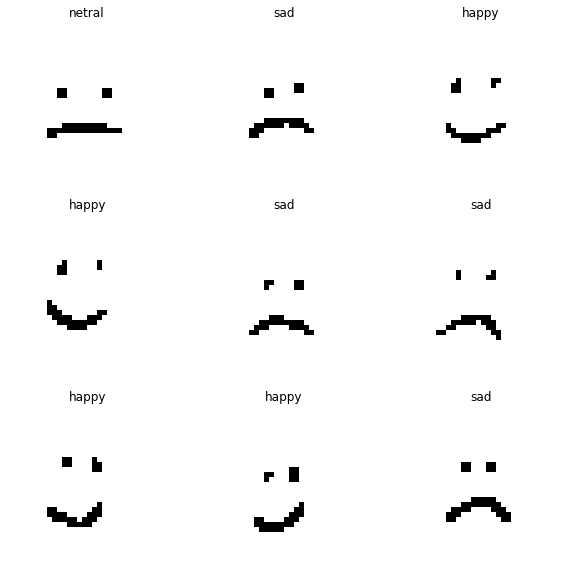

In [13]:
from PIL import Image
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = Image.fromarray(images[i].numpy().reshape((images.shape[1], -1)))
    plt.imshow(img)
    plt.title(data_train.class_names[labels[i]])
    plt.axis("off")

### Применение моделей нейронной сети для классификации изображений

  Настройка набора данных для повышения производительности 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

data_train = data_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

Функция вывода графика обучения

In [15]:
def plot_train_history(history, layers_str: str, epochs: int, batch_size: int, 
                       learning_rate: float, optimizer_name: str, loss_function_name: str, 
                       db_name: str, img_dir: str, ds_split_variant=1):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)
  plt.figure(figsize=(16, 12))

  plt.subplot(2, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Accurancy')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim((0, 1))
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Accuracy')


  max_loss = max(loss)
  if max_loss < max(val_loss):
    max_loss = max(val_loss)
  
  plt.subplot(2, 2, 3)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.ylim((0, max_loss + 0.1))
  plt.legend(loc='upper right')
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Loss')

  description = f'Database: {db_name} \
    \nLayers (Activation Funcs):\n {layers_str} \
    \nEpochs: {epochs} \
    \nBatch Size: {batch_size} \
    \nOptimizer: {optimizer_name} \
    \nLearning Rate: {learning_rate}\
    \nLoss Function: {loss_function_name}\
    \nFinal Train Loss: {loss[-1]:.3f}\
    \nFinal Train Accuracy: {(acc[-1]*100):.2f}%\
    \nFinal Valid Loss: {val_loss[-1]:.3f}\
    \nFinal Valid Accuracy: {(val_acc[-1]*100):.2f}%'


  if ds_split_variant == 1:
    ds_split='50% / 50%'
  else:
    ds_split='80% / 20%'
  ALL_HISTORY.loc[ALL_HISTORY.shape[0]] = [ds_split, epochs, batch_size, layers_str, optimizer_name, 
                                    learning_rate, loss_function_name, f'{(acc[-1]*100):.2f}%',
                                    f'{(val_acc[-1]*100):.2f}%', f'{loss[-1]:.3f}', f'{val_loss[-1]:.3f}']

  img_name = f'NN Training. Epochs({epochs}) Optim({optimizer_name}) LearningRate({learning_rate}) LossFunc({loss_function_name}) {ALL_HISTORY.shape[0]}.png'
  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

  plt.subplot(2, 2, 2)
  plt.axis("off")
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  plt.text(x=0.0, y=1.0, s=description, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
  plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
  plt.show()

  return description

#### Применение моделей нейронной сети с различными гиперпараметрами

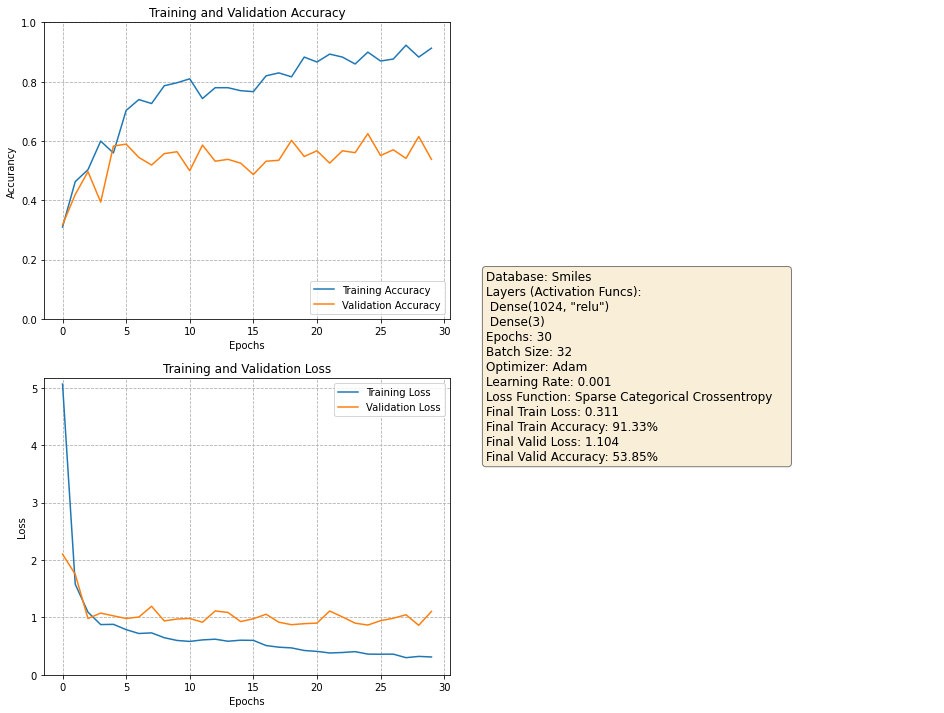

Database: Smiles     
Layers (Activation Funcs):
 Dense(1024, "relu")
 Dense(3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.311    
Final Train Accuracy: 91.33%    
Final Valid Loss: 1.104    
Final Valid Accuracy: 53.85%


In [16]:
  layers_str = f'Dense({32*32}, "relu")\n Dense({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)), Flatten(),
                      Dense(32*32, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

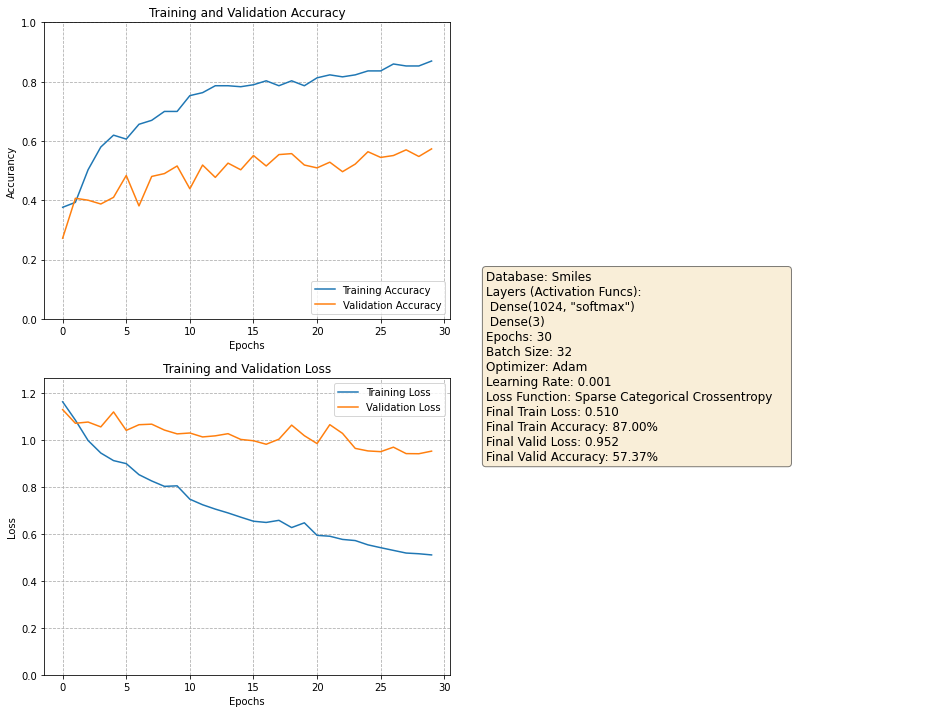

Database: Smiles     
Layers (Activation Funcs):
 Dense(1024, "softmax")
 Dense(3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.510    
Final Train Accuracy: 87.00%    
Final Valid Loss: 0.952    
Final Valid Accuracy: 57.37%


In [17]:
  layers_str = f'Dense({32*32}, "softmax")\n Dense({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)), Flatten(),
                      Dense(3, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

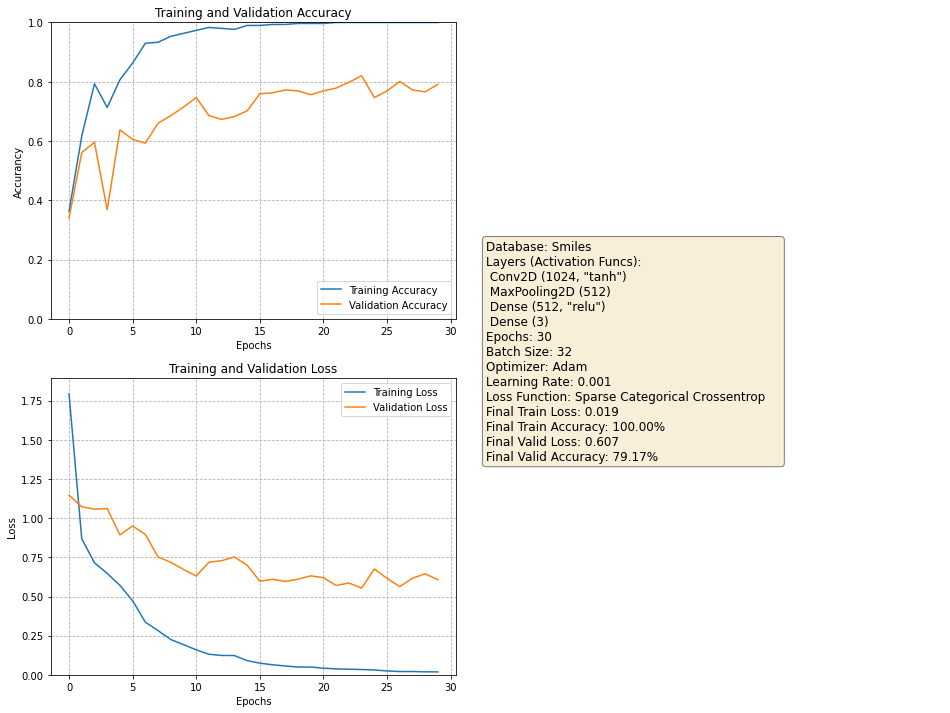

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.019    
Final Train Accuracy: 100.00%    
Final Valid Loss: 0.607    
Final Valid Accuracy: 79.17%


In [18]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "relu")\n Dense ({num_classes})'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='relu'), Dense(num_classes)])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

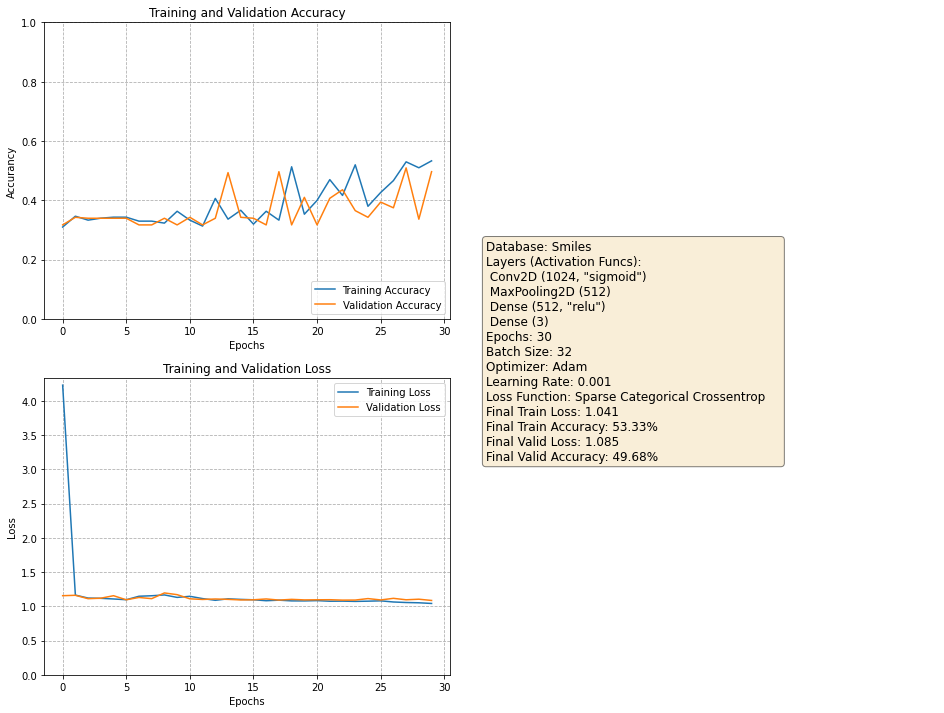

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Dense (512, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 1.041    
Final Train Accuracy: 53.33%    
Final Valid Loss: 1.085    
Final Valid Accuracy: 49.68%


In [19]:
layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "relu")\n Dense ({num_classes})'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='relu'), Dense(num_classes)])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

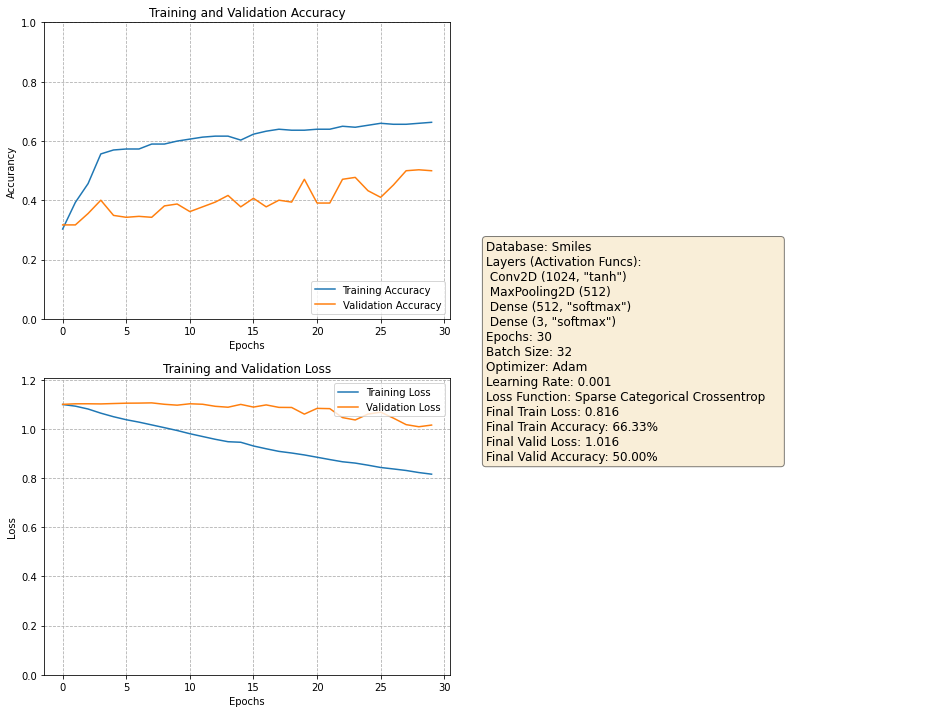

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.816    
Final Train Accuracy: 66.33%    
Final Valid Loss: 1.016    
Final Valid Accuracy: 50.00%


In [20]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax'), Dense(num_classes, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

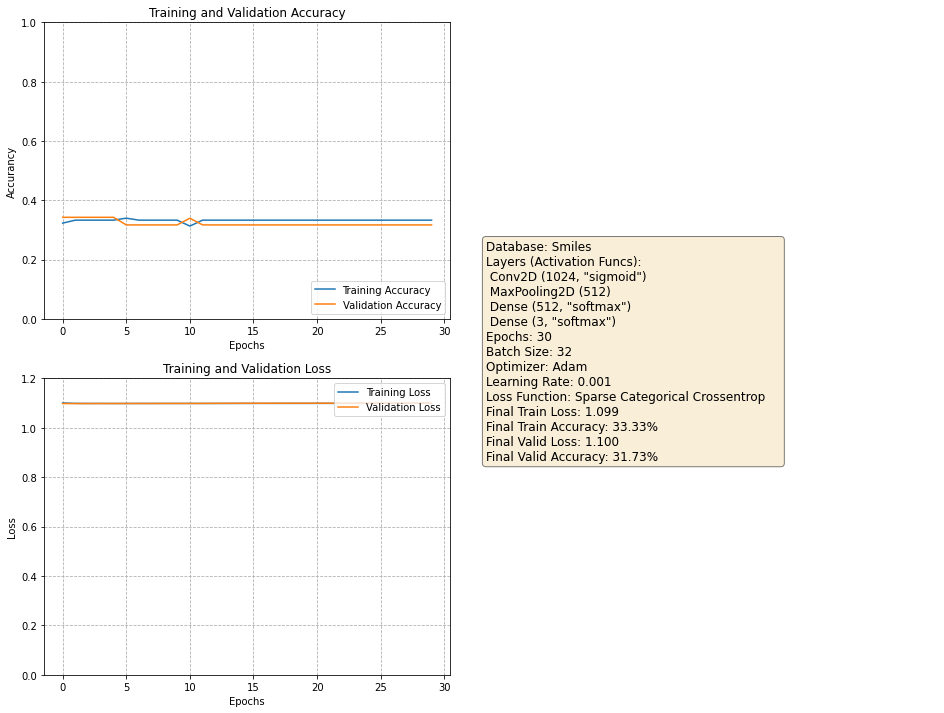

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Dense (512, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 1.099    
Final Train Accuracy: 33.33%    
Final Valid Loss: 1.100    
Final Valid Accuracy: 31.73%


In [21]:
layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax'), Dense(num_classes, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

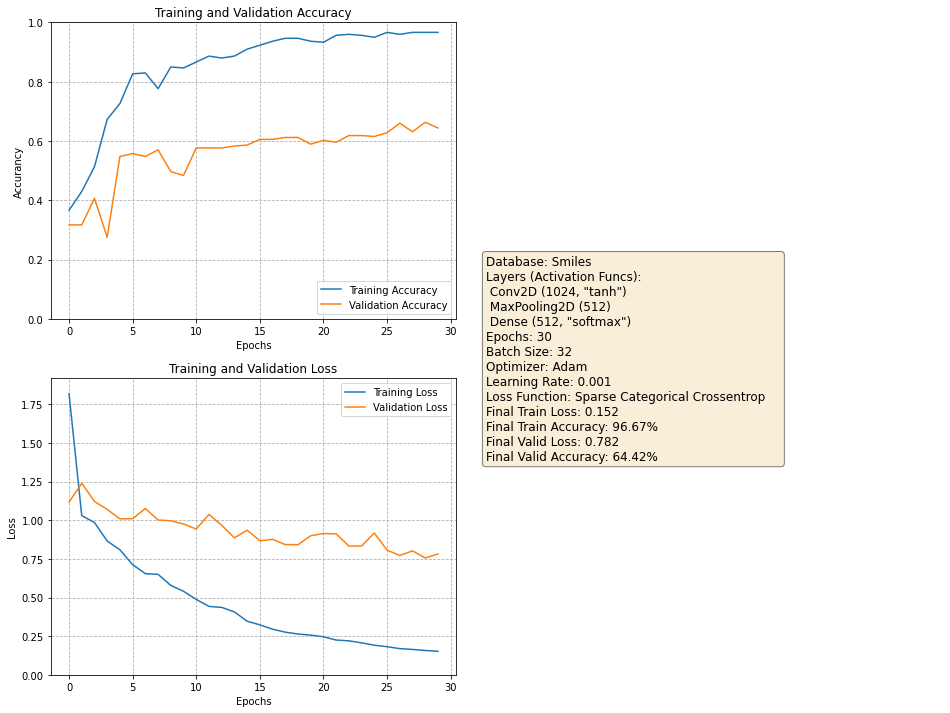

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.152    
Final Train Accuracy: 96.67%    
Final Valid Loss: 0.782    
Final Valid Accuracy: 64.42%


In [22]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

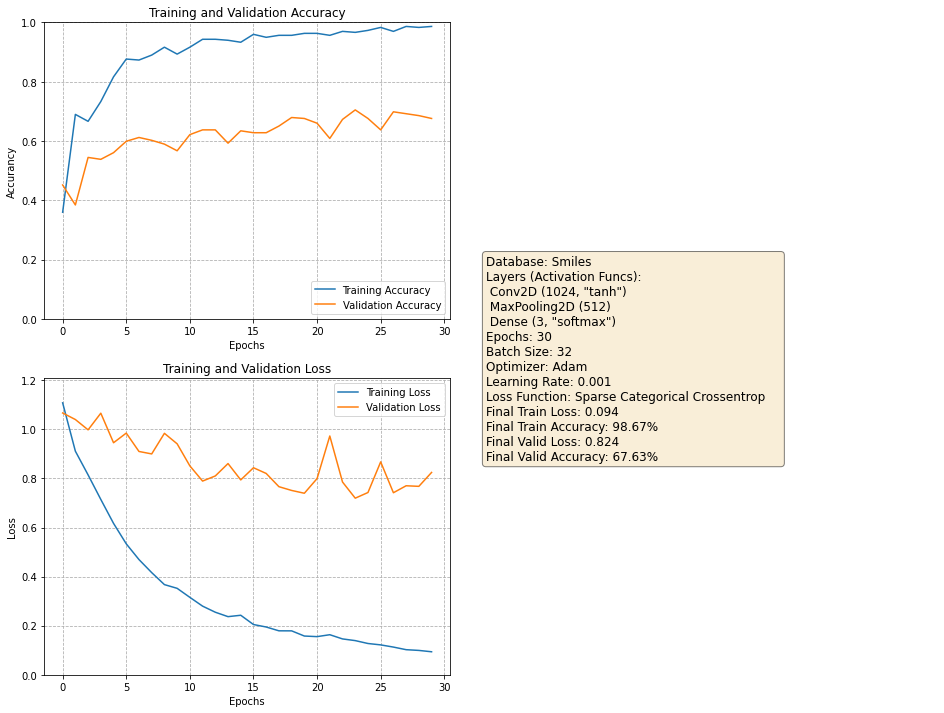

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.094    
Final Train Accuracy: 98.67%    
Final Valid Loss: 0.824    
Final Valid Accuracy: 67.63%


In [23]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(3, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir))

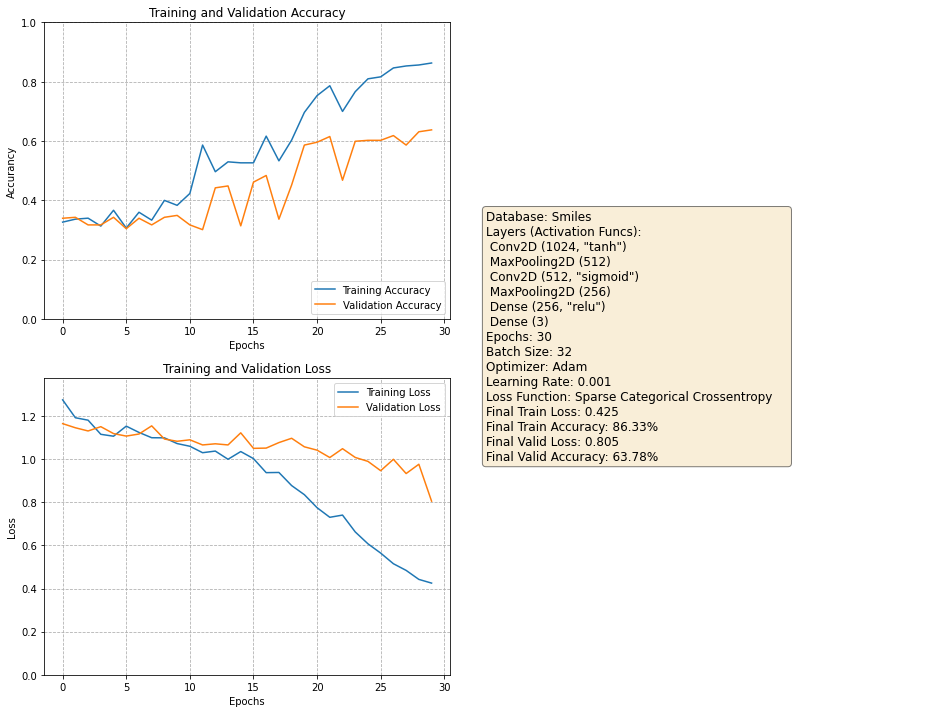

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Conv2D (512, "sigmoid")
 MaxPooling2D (256)              
 Dense (256, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.425    
Final Train Accuracy: 86.33%    
Final Valid Loss: 0.805    
Final Valid Accuracy: 63.78%


In [24]:
  layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "sigmoid")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "relu")\n Dense ({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

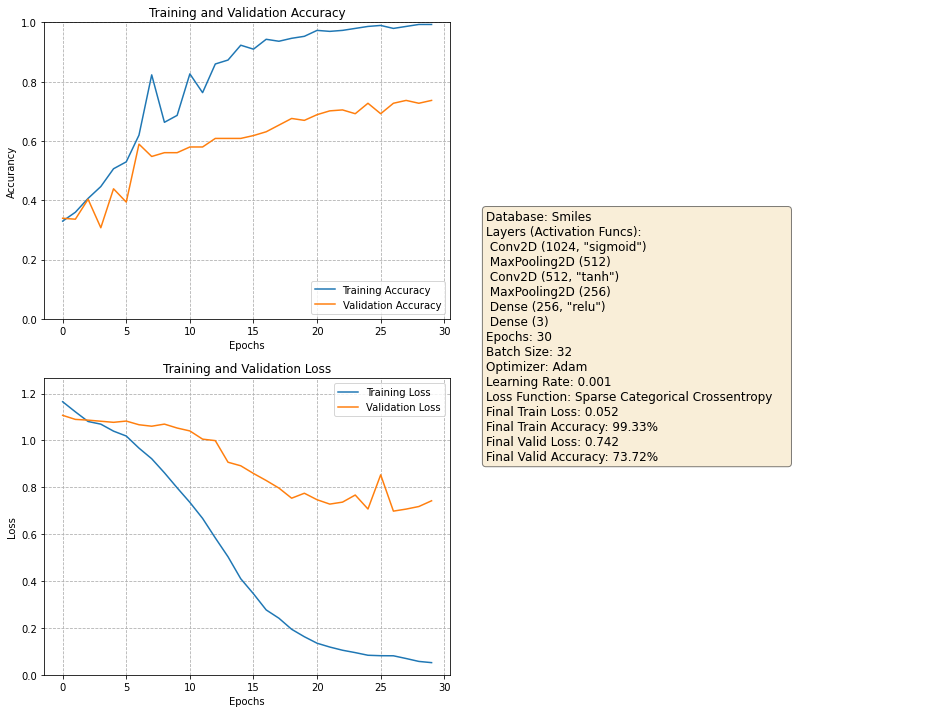

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Conv2D (512, "tanh")
 MaxPooling2D (256)              
 Dense (256, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.052    
Final Train Accuracy: 99.33%    
Final Valid Loss: 0.742    
Final Valid Accuracy: 73.72%


In [25]:
  layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "tanh")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "relu")\n Dense ({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

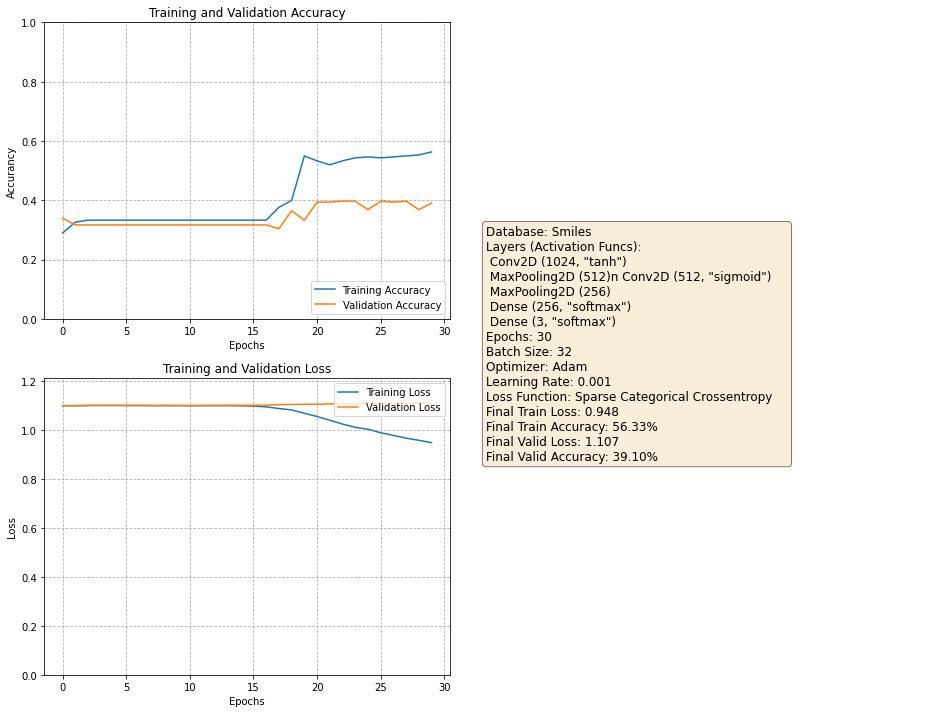

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)n Conv2D (512, "sigmoid")
 MaxPooling2D (256)              
 Dense (256, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.948    
Final Train Accuracy: 56.33%    
Final Valid Loss: 1.107    
Final Valid Accuracy: 39.10%


In [26]:
  layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})n Conv2D ({32*16}, "sigmoid")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "softmax")\n Dense ({num_classes}, "softmax")'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='softmax'), Dense(num_classes, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

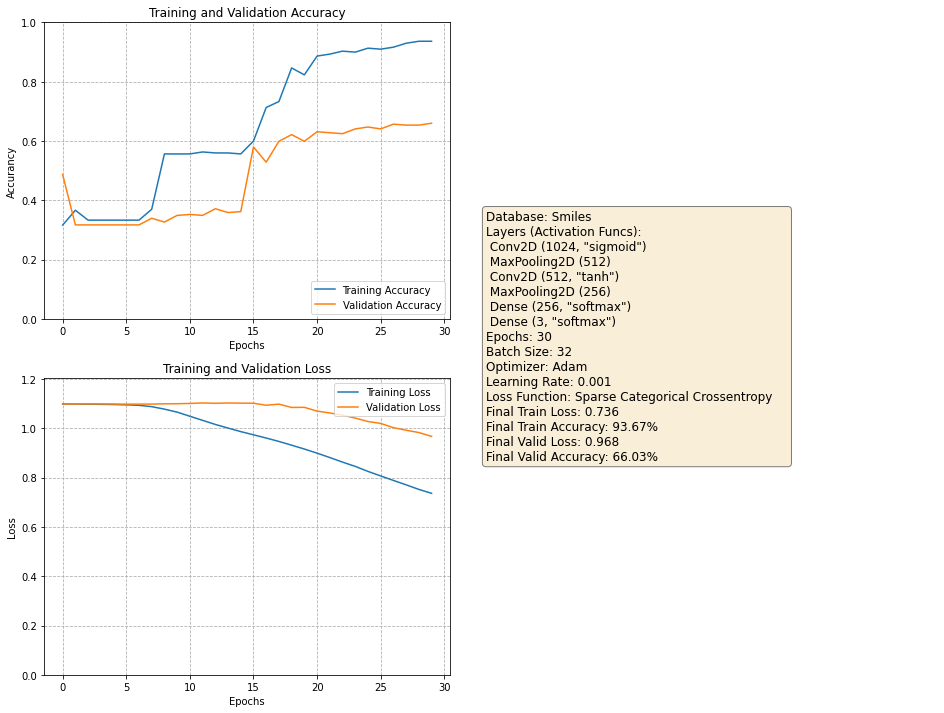

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Conv2D (512, "tanh")
 MaxPooling2D (256)              
 Dense (256, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.736    
Final Train Accuracy: 93.67%    
Final Valid Loss: 0.968    
Final Valid Accuracy: 66.03%


In [27]:
  layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "tanh")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "softmax")\n Dense ({num_classes}, "softmax")'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='softmax'), Dense(num_classes, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir))

##### Вывод результатов работы различных моделей нейронной сети в одной таблице

In [28]:
ALL_HISTORY[:]

,Dataset Split Variant,Epoches,Batch Size,Layers,Optimizer,Learning Rate,Loss Function,Final Train Accuracy,Final Valid Accuracy,Final Train Loss,Final Valid Loss
0,50% / 50%,30,32,"Dense(1024, ""relu"")\n Dense(3)",Adam,0.001,Sparse Categorical Crossentropy,91.33%,53.85%,0.311,1.104
1,50% / 50%,30,32,"Dense(1024, ""softmax"")\n Dense(3)",Adam,0.001,Sparse Categorical Crossentropy,87.00%,57.37%,0.510,0.952
2,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,100.00%,79.17%,0.019,0.607
3,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentrop,53.33%,49.68%,1.041,1.085
4,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,66.33%,50.00%,0.816,1.016
5,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentrop,33.33%,31.73%,1.099,1.100
6,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,96.67%,64.42%,0.152,0.782
7,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,98.67%,67.63%,0.094,0.824
8,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n C...",Adam,0.001,Sparse Categorical Crossentropy,86.33%,63.78%,0.425,0.805
9,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentropy,99.33%,73.72%,0.052,0.742


## Применение моделей нейронной сети при распределении данных `train` и `test` по всем изображениям смайликов в процентном соотношении 80/20

Получение списков названий изображений по категориям

In [29]:
happy_all = list(filter(re.compile('happy.').match, onlyfiles))
netral_all = list(filter(re.compile('netral.').match, onlyfiles))
sad_all = list(filter(re.compile('sad.').match, onlyfiles))

Создание директорий и копирование в них изображений так, чтобы в наборе `train` находилось 80% всех изображений

In [30]:
if os.path.exists('data80to20') is False:
  !mkdir -p data80to20/happy/ data80to20/sad/ data80to20/netral/
  
  copy_images_to(happy_all, 'smiles', 'data80to20/happy/')
  copy_images_to(sad_all, 'smiles', 'data80to20/sad/')
  copy_images_to(netral_all, 'smiles', 'data80to20/netral/')

data80to20/happy/smiles count: 207
data80to20/sad/smiles count: 199
data80to20/netral/smiles count: 206


Получение наборов данных `train` и `test` для нейронной сети


In [31]:
data_train = image_dataset_from_directory(directory='/content/data80to20/', class_names=['happy', 'netral', 'sad'], 
                                          color_mode='grayscale', batch_size=32, image_size=(32, 32), shuffle=True, 
                                          seed=42, validation_split=0.2, subset='training')

data_test = image_dataset_from_directory(directory='/content/data80to20/', class_names=['happy', 'netral', 'sad'], 
                                         color_mode='grayscale', batch_size=32, image_size=(32, 32), shuffle=True, 
                                         seed=42, validation_split=0.2, subset='validation')

Found 612 files belonging to 3 classes.
Using 490 files for training.
Found 612 files belonging to 3 classes.
Using 122 files for validation.


  Настройка набора данных для повышения производительности 

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

data_train = data_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

#### Применение моделей нейронной сети с различными гиперпараметрами

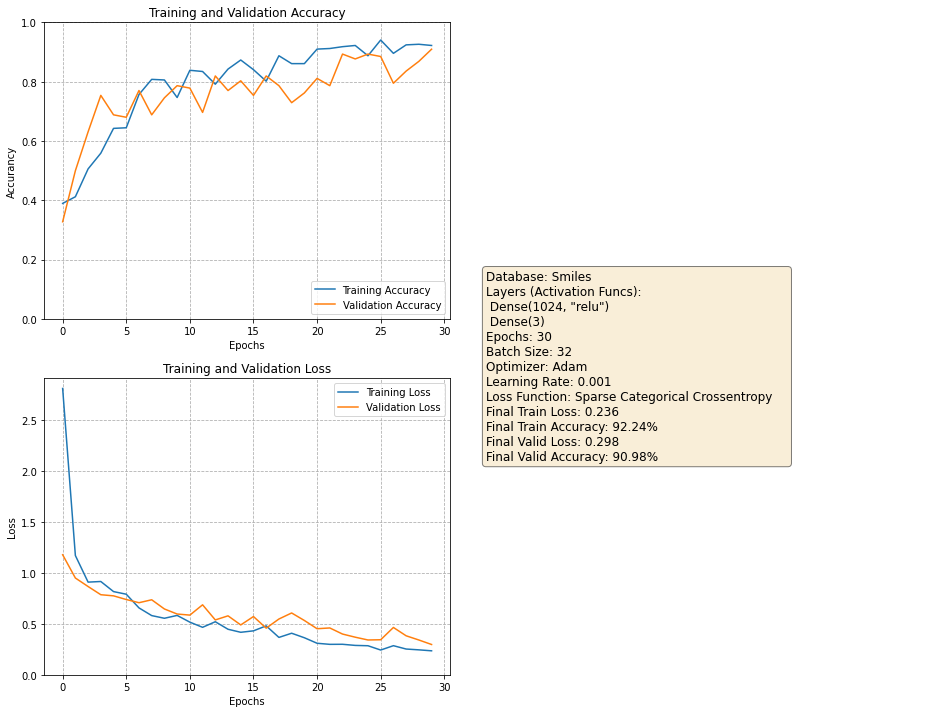

Database: Smiles     
Layers (Activation Funcs):
 Dense(1024, "relu")
 Dense(3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.236    
Final Train Accuracy: 92.24%    
Final Valid Loss: 0.298    
Final Valid Accuracy: 90.98%


In [33]:
  layers_str = f'Dense({32*32}, "relu")\n Dense({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)), Flatten(),
                      Dense(32*32, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

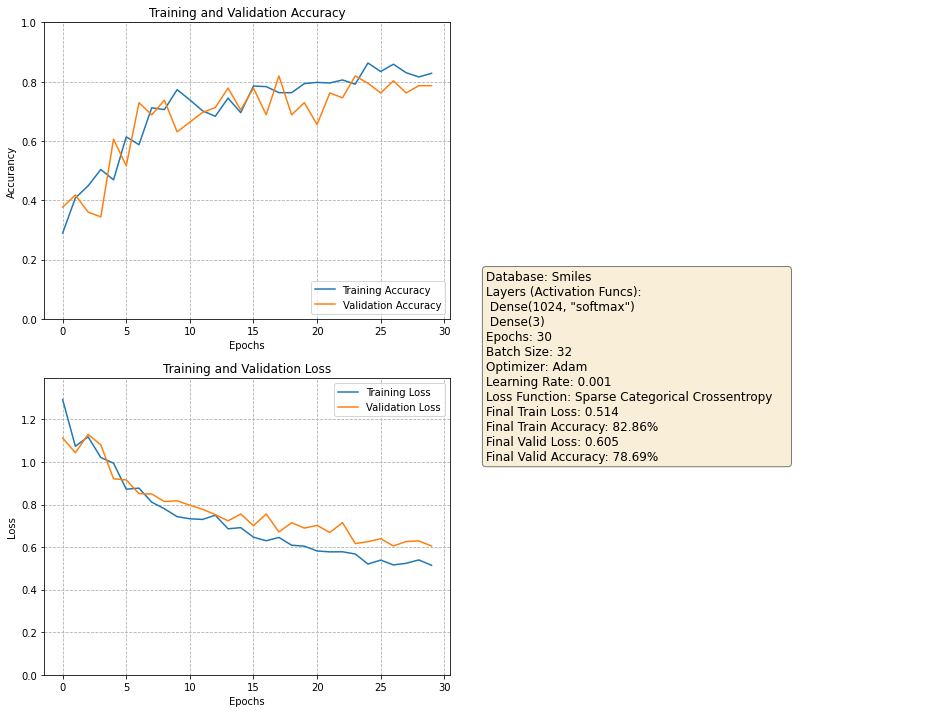

Database: Smiles     
Layers (Activation Funcs):
 Dense(1024, "softmax")
 Dense(3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.514    
Final Train Accuracy: 82.86%    
Final Valid Loss: 0.605    
Final Valid Accuracy: 78.69%


In [34]:
  layers_str = f'Dense({32*32}, "softmax")\n Dense({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)), Flatten(),
                      Dense(3, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

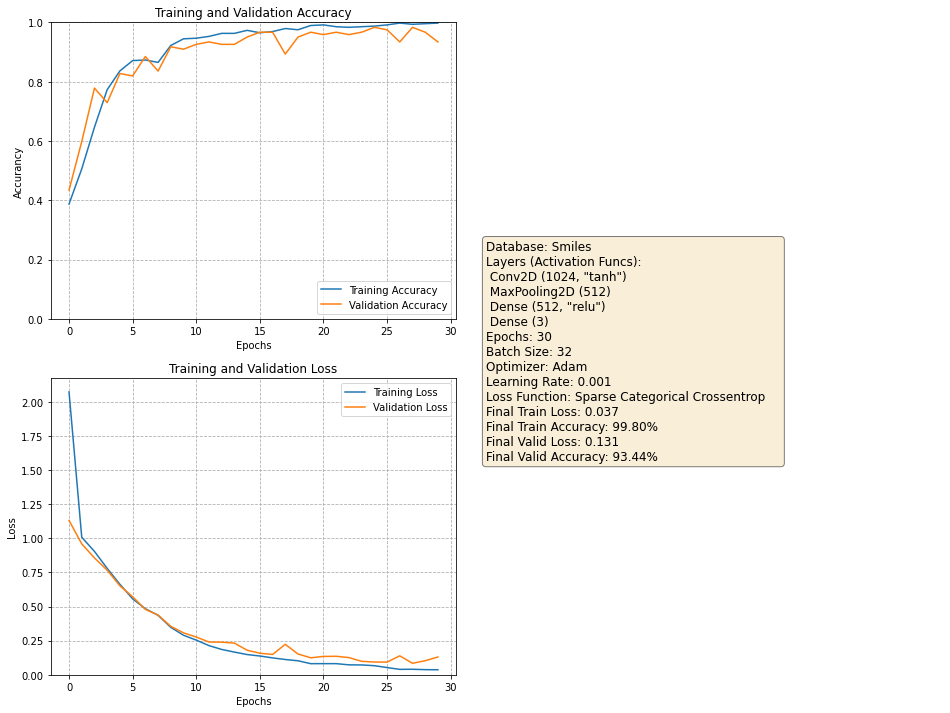

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.037    
Final Train Accuracy: 99.80%    
Final Valid Loss: 0.131    
Final Valid Accuracy: 93.44%


In [35]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "relu")\n Dense ({num_classes})'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='relu'), Dense(num_classes)])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

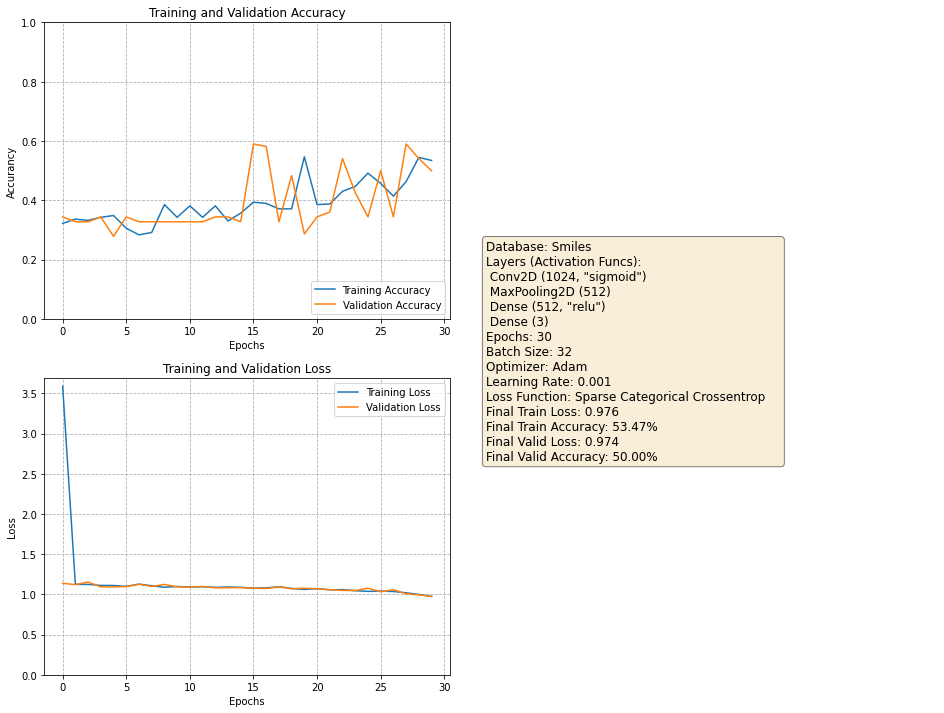

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Dense (512, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.976    
Final Train Accuracy: 53.47%    
Final Valid Loss: 0.974    
Final Valid Accuracy: 50.00%


In [36]:
layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "relu")\n Dense ({num_classes})'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='relu'), Dense(num_classes)])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

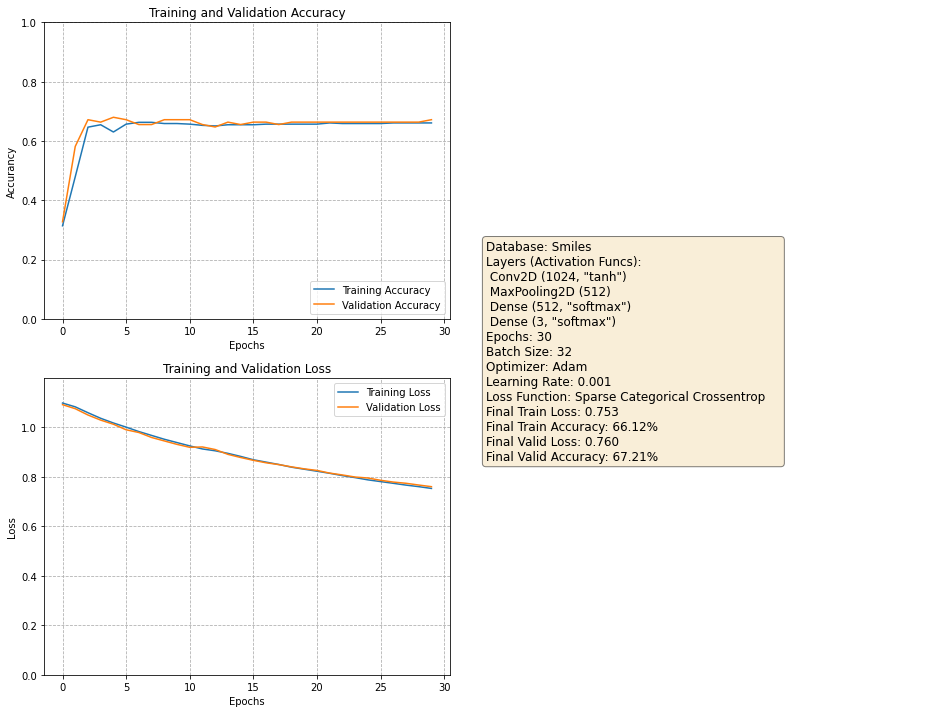

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.753    
Final Train Accuracy: 66.12%    
Final Valid Loss: 0.760    
Final Valid Accuracy: 67.21%


In [37]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax'), Dense(num_classes, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir,ds_split_variant=0))

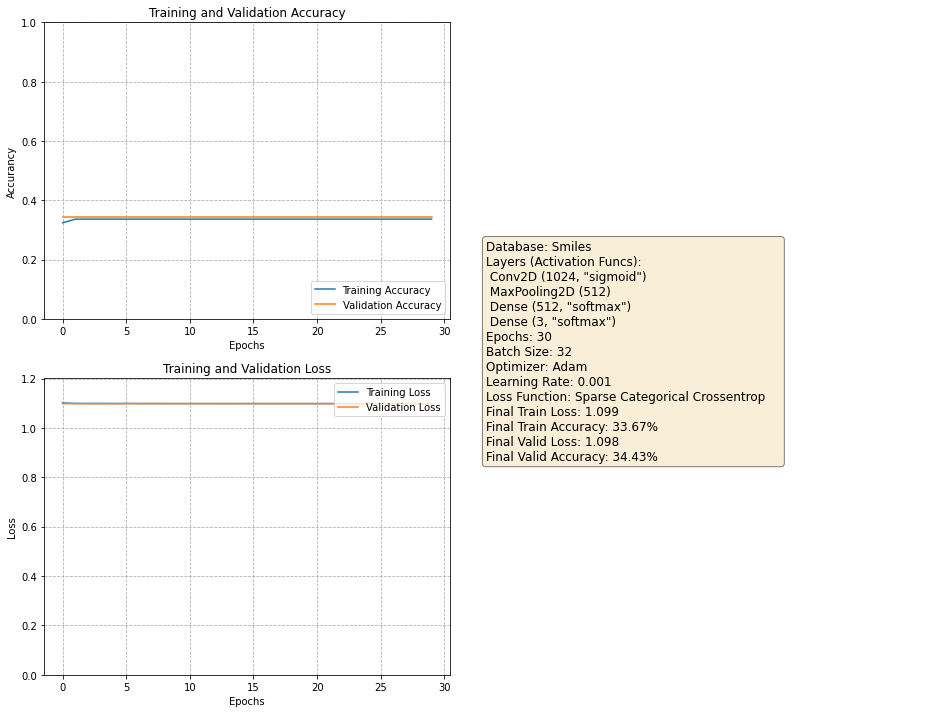

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Dense (512, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 1.099    
Final Train Accuracy: 33.67%    
Final Valid Loss: 1.098    
Final Valid Accuracy: 34.43%


In [38]:
layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax'), Dense(num_classes, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

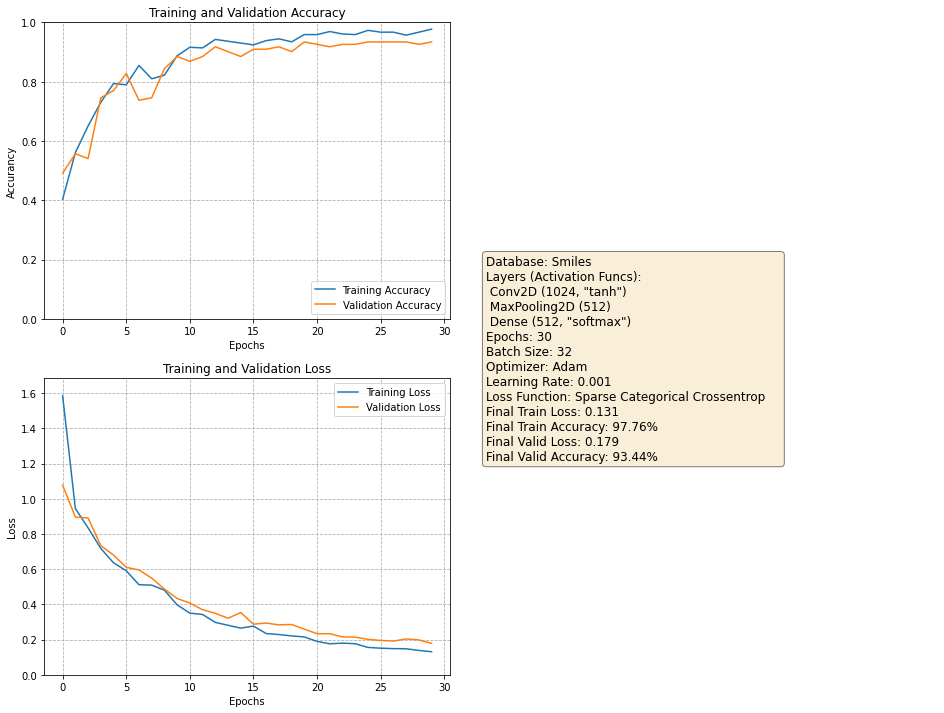

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (512, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.131    
Final Train Accuracy: 97.76%    
Final Valid Loss: 0.179    
Final Valid Accuracy: 93.44%


In [39]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({32*16}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(32*16, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

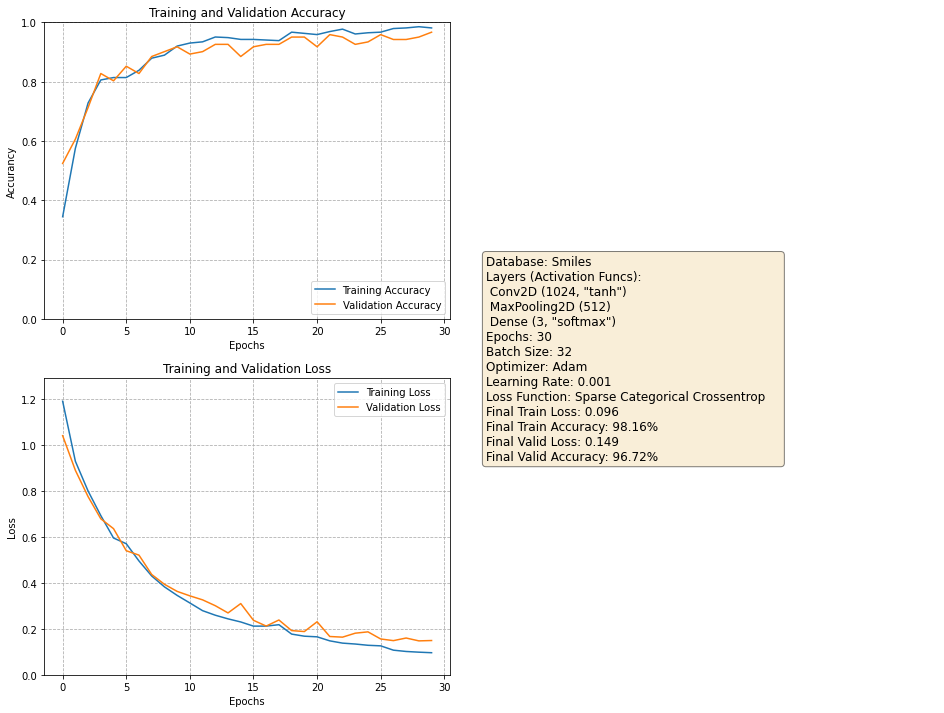

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentrop    
Final Train Loss: 0.096    
Final Train Accuracy: 98.16%    
Final Valid Loss: 0.149    
Final Valid Accuracy: 96.72%


In [40]:
layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Dense ({num_classes}, "softmax")'

model_adam = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                        layers.Conv2D(16, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                        Flatten(), Dense(3, activation='softmax')])
model_adam.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_adam.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                        optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentrop', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

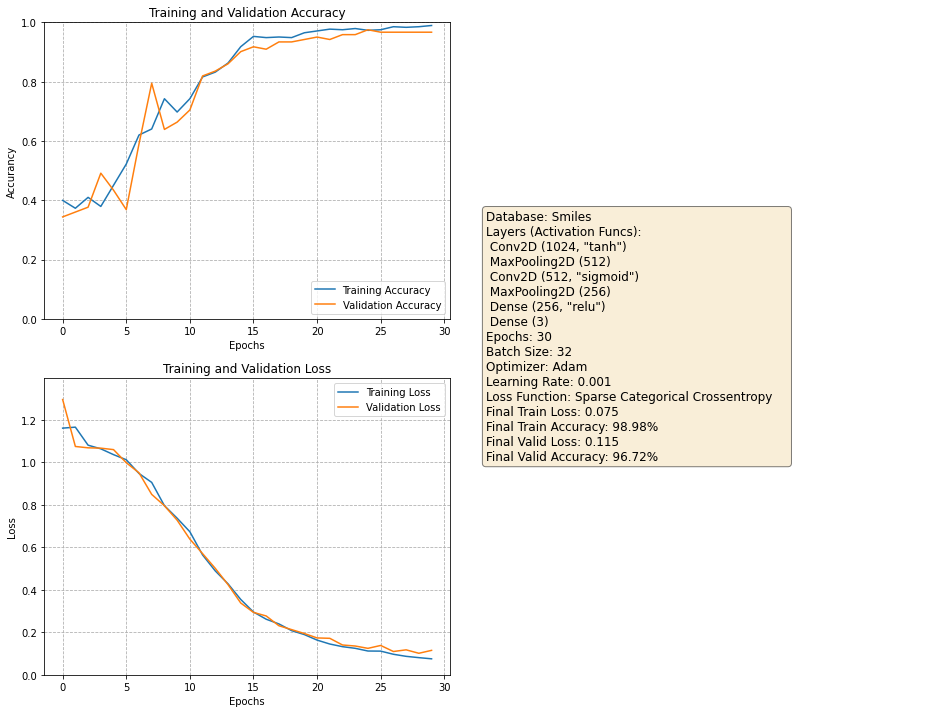

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)
 Conv2D (512, "sigmoid")
 MaxPooling2D (256)              
 Dense (256, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.075    
Final Train Accuracy: 98.98%    
Final Valid Loss: 0.115    
Final Valid Accuracy: 96.72%


In [41]:
  layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "sigmoid")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "relu")\n Dense ({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

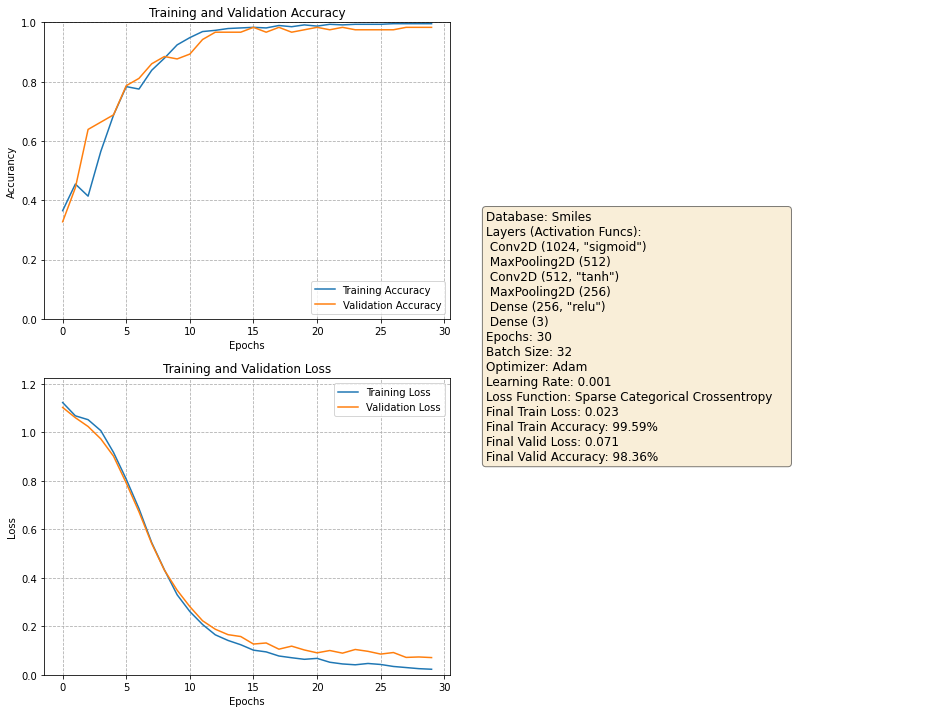

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Conv2D (512, "tanh")
 MaxPooling2D (256)              
 Dense (256, "relu")
 Dense (3)     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.023    
Final Train Accuracy: 99.59%    
Final Valid Loss: 0.071    
Final Valid Accuracy: 98.36%


In [42]:
  layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "tanh")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "relu")\n Dense ({num_classes})'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='relu'), Dense(num_classes)])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

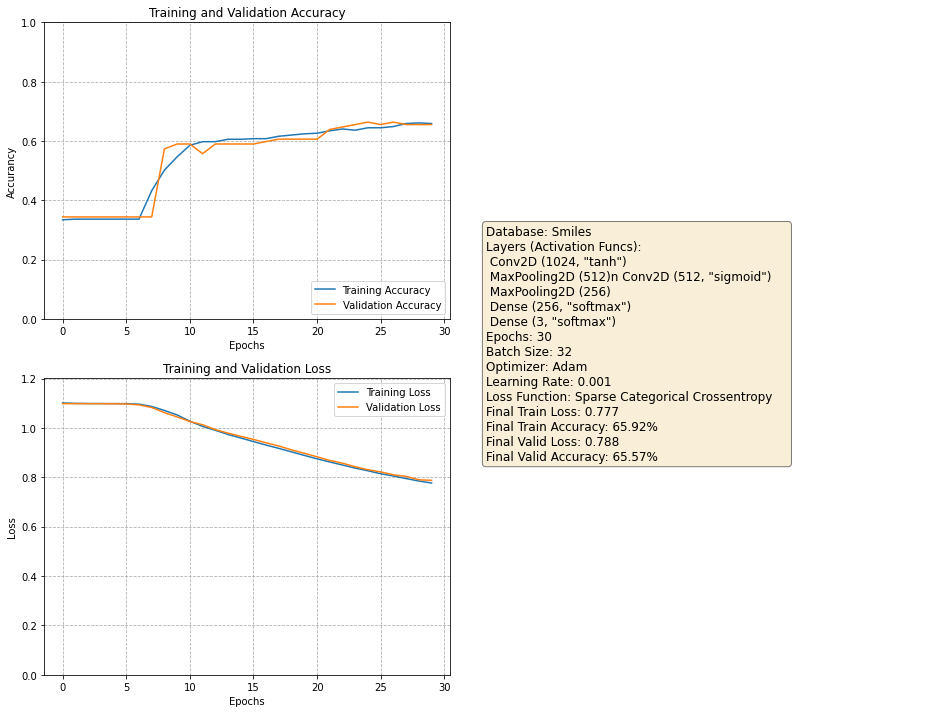

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "tanh")
 MaxPooling2D (512)n Conv2D (512, "sigmoid")
 MaxPooling2D (256)              
 Dense (256, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.777    
Final Train Accuracy: 65.92%    
Final Valid Loss: 0.788    
Final Valid Accuracy: 65.57%


In [43]:
  layers_str = f'Conv2D ({32*32}, "tanh")\n MaxPooling2D ({32*16})n Conv2D ({32*16}, "sigmoid")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "softmax")\n Dense ({num_classes}, "softmax")'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='softmax'), Dense(num_classes, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

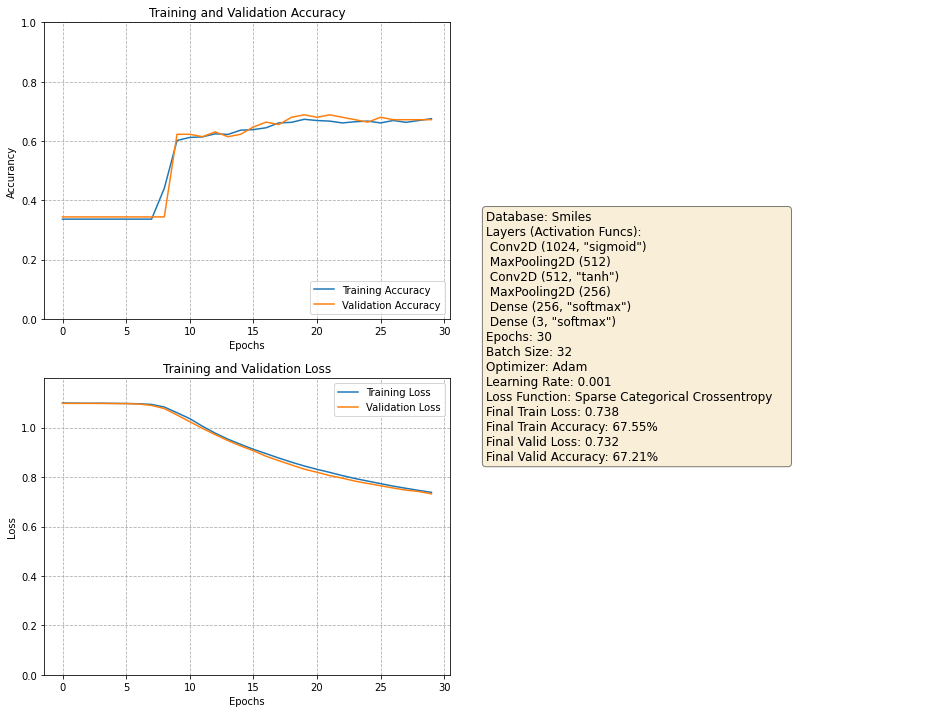

Database: Smiles     
Layers (Activation Funcs):
 Conv2D (1024, "sigmoid")
 MaxPooling2D (512)
 Conv2D (512, "tanh")
 MaxPooling2D (256)              
 Dense (256, "softmax")
 Dense (3, "softmax")     
Epochs: 30     
Batch Size: 32     
Optimizer: Adam     
Learning Rate: 0.001    
Loss Function: Sparse Categorical Crossentropy    
Final Train Loss: 0.738    
Final Train Accuracy: 67.55%    
Final Valid Loss: 0.732    
Final Valid Accuracy: 67.21%


In [44]:
  layers_str = f'Conv2D ({32*32}, "sigmoid")\n MaxPooling2D ({32*16})\n Conv2D ({32*16}, "tanh")\n MaxPooling2D ({16*16})\
                \n Dense ({16*16}, "softmax")\n Dense ({num_classes}, "softmax")'

  model = Sequential([Rescaling(1./255, input_shape=(32, 32, 1)),
                          layers.Conv2D(4, 3, padding='same', activation='sigmoid'), layers.MaxPooling2D(),
                          layers.Conv2D(8, 3, padding='same', activation='tanh'), layers.MaxPooling2D(),
                          Flatten(), Dense(16*16, activation='softmax'), Dense(num_classes, activation='softmax')])
  model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  history = model.fit(data_train, validation_data=data_test, epochs=epochs, batch_size=batch_size, verbose=0)
  print(plot_train_history(history, layers_str=layers_str, epochs=epochs, batch_size=batch_size, learning_rate=0.001,
                          optimizer_name='Adam', loss_function_name='Sparse Categorical Crossentropy', db_name='Smiles', img_dir=img_dir, ds_split_variant=0))

#### Вывод результатов работы различных моделей нейронной сети в одной таблице

In [45]:
ALL_HISTORY[:]

,Dataset Split Variant,Epoches,Batch Size,Layers,Optimizer,Learning Rate,Loss Function,Final Train Accuracy,Final Valid Accuracy,Final Train Loss,Final Valid Loss
0,50% / 50%,30,32,"Dense(1024, ""relu"")\n Dense(3)",Adam,0.001,Sparse Categorical Crossentropy,91.33%,53.85%,0.311,1.104
1,50% / 50%,30,32,"Dense(1024, ""softmax"")\n Dense(3)",Adam,0.001,Sparse Categorical Crossentropy,87.00%,57.37%,0.510,0.952
2,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,100.00%,79.17%,0.019,0.607
3,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentrop,53.33%,49.68%,1.041,1.085
4,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,66.33%,50.00%,0.816,1.016
5,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentrop,33.33%,31.73%,1.099,1.100
6,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,96.67%,64.42%,0.152,0.782
7,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n D...",Adam,0.001,Sparse Categorical Crossentrop,98.67%,67.63%,0.094,0.824
8,50% / 50%,30,32,"Conv2D (1024, ""tanh"")\n MaxPooling2D (512)\n C...",Adam,0.001,Sparse Categorical Crossentropy,86.33%,63.78%,0.425,0.805
9,50% / 50%,30,32,"Conv2D (1024, ""sigmoid"")\n MaxPooling2D (512)\...",Adam,0.001,Sparse Categorical Crossentropy,99.33%,73.72%,0.052,0.742


In [46]:
# архивирование папки с графиками
!zip -r /content/graphics.zip /content/graphics

  adding: content/graphics/ (stored 0%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentropy) 2.png (deflated 8%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentrop) 16.png (deflated 9%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentrop) 3.png (deflated 8%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentrop) 7.png (deflated 8%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentropy) 10.png (deflated 7%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFunc(Sparse Categorical Crossentropy) 22.png (deflated 8%)
  adding: content/graphics/NN Training. Epochs(30) Optim(Adam) LearningRate(0.001) LossFun

In [47]:
# скачивание архива себе на ПК
from google.colab import files
files.download("/content/graphics.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>